In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_SIZE = 128
NUM_CLASSES = 4  # HGC, LGC, NST, NTL
TIMESTEPS = 1000
EPOCHS = 200
BATCH_SIZE = 16

In [3]:
LABEL_MAP = {
    "HGC": 0,
    "LGC": 1,
    "NST": 2,
    "NTL": 3
}

In [4]:
# Kaggle paths (update dataset name as needed)
TRAIN_CSV = "/kaggle/input/ebt-dataset/train.csv"

train_df = pd.read_csv(TRAIN_CSV)

# Map tissue type -> integer label
train_df["label"] = train_df["tissue type"].map(LABEL_MAP)

# Keep only what the Dataset needs
train_df = train_df[["HLY", "label"]].dropna().reset_index(drop=True)
train_df["label"] = train_df["label"].astype(int)

print("Rows:", len(train_df))
print(train_df["label"].value_counts().sort_index())

Rows: 1224
label
0    309
1    482
2    346
3     87
Name: count, dtype: int64


In [5]:
class DiffusionDataset(Dataset):
    def __init__(self, df, img_dir=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.CenterCrop(IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.5] * 3, [0.5] * 3),  # [-1, 1]
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        hly = self.df.iloc[idx]["HLY"]
        img_path = hly
        if self.img_dir and not os.path.isabs(img_path):
            img_path = os.path.join(self.img_dir, img_path)

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")

        image = Image.open(img_path).convert("RGB")
        label = int(self.df.iloc[idx]["label"])
        return self.transform(image), label

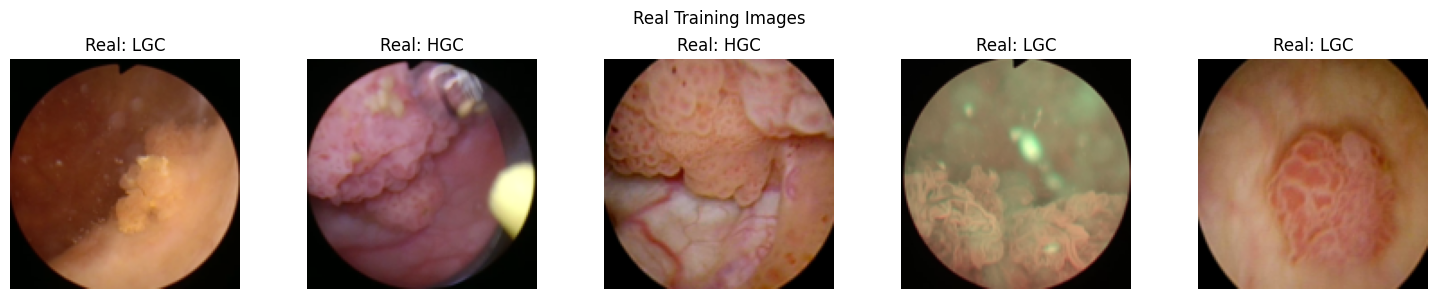

In [6]:
# Visualize real training images for comparison
sample_dataset = DiffusionDataset(train_df.sample(5, random_state=42))
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img, label = sample_dataset[i]
    img = (img + 1) / 2  # [-1,1] -> [0,1]
    img = img.permute(1, 2, 0).numpy().clip(0, 1)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Real: {list(LABEL_MAP.keys())[label]}')
plt.suptitle('Real Training Images')
plt.tight_layout()
plt.show()

In [7]:
def linear_beta_schedule(timesteps):
    return torch.linspace(1e-4, 0.02, timesteps)


def add_noise(x0, t, betas):
    noise = torch.randn_like(x0)
    alphas = 1. - betas
    alpha_hat = torch.cumprod(alphas, dim=0)

    sqrt_alpha_hat = alpha_hat[t].view(-1,1,1,1).sqrt()
    sqrt_one_minus = (1 - alpha_hat[t]).view(-1,1,1,1).sqrt()

    return sqrt_alpha_hat * x0 + sqrt_one_minus * noise, noise

In [8]:
class ImprovedUNet(nn.Module):
    def __init__(self, num_classes, timesteps):
        super().__init__()
        # Sinusoidal time embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(timesteps, 128),
            nn.SiLU(),
            nn.Linear(128, 128)
        )
        # Class embedding
        self.class_emb = nn.Embedding(num_classes, 128)
        
        # Initial projection
        self.conv0 = nn.Conv2d(3, 64, 3, padding=1)
        
        # Encoder with skip connections
        self.down1 = self._make_layer(64, 128)
        self.down2 = self._make_layer(128, 256)
        self.down3 = self._make_layer(256, 512)
        
        # Bottleneck
        self.bottleneck = self._make_layer(512, 512)
        
        # Decoder with skip connections
        self.up1 = self._make_layer(512 + 512, 256)
        self.up2 = self._make_layer(256 + 256, 128)
        self.up3 = self._make_layer(128 + 128, 64)
        
        # Output
        self.out = nn.Conv2d(64, 3, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
    def _make_layer(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU()
        )
    
    def forward(self, x, t, y):
        # Create one-hot time vector
        t_onehot = torch.zeros(x.size(0), TIMESTEPS, device=x.device)
        if t.ndim == 0:
            t = t.expand(x.size(0))
        t_onehot.scatter_(1, t.unsqueeze(1), 1)
        
        # Embeddings
        t_emb = self.time_mlp(t_onehot)  # (N, 128)
        c_emb = self.class_emb(y)  # (N, 128)
        cond = (t_emb + c_emb).view(x.size(0), 128, 1, 1)
        
        # Initial conv
        x = self.conv0(x)
        x = x + cond[:, :64]  # Add conditioning to first 64 channels
        
        # Encoder
        x1 = self.down1(x)
        x = self.pool(x1)
        
        x2 = self.down2(x)
        x = self.pool(x2)
        
        x3 = self.down3(x)
        x = self.pool(x3)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder with skip connections
        x = self.upsample(x)
        x = torch.cat([x, x3], dim=1)
        x = self.up1(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up3(x)
        
        return self.out(x)

In [9]:
betas = linear_beta_schedule(TIMESTEPS).to(DEVICE)

train_dataset = DiffusionDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# Use improved architecture
model = ImprovedUNet(NUM_CLASSES, TIMESTEPS).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

# Track losses
loss_history = []

for epoch in range(EPOCHS):
    model.train()
    epoch_losses = []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for x, y in pbar:
        x, y = x.to(DEVICE), y.to(DEVICE)
        t = torch.randint(0, TIMESTEPS, (x.size(0),), device=DEVICE, dtype=torch.long)

        xt, noise = add_noise(x, t, betas)
        noise_pred = model(xt, t, y)

        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    avg_loss = sum(epoch_losses) / len(epoch_losses)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS} - Avg Loss: {avg_loss:.4f}")

torch.save(model.state_dict(), "/kaggle/working/diffusion_model_v2.pth")
print("Model saved to /kaggle/working/diffusion_model_v2.pth")

Epoch 1/200: 100%|██████████| 77/77 [00:14<00:00,  5.18it/s, loss=0.0505]


Epoch 1/200 - Avg Loss: 0.2720


Epoch 2/200: 100%|██████████| 77/77 [00:13<00:00,  5.71it/s, loss=0.1199]


Epoch 2/200 - Avg Loss: 0.0626


Epoch 3/200: 100%|██████████| 77/77 [00:13<00:00,  5.70it/s, loss=0.0394]


Epoch 3/200 - Avg Loss: 0.0629


Epoch 4/200: 100%|██████████| 77/77 [00:13<00:00,  5.68it/s, loss=0.1088]


Epoch 4/200 - Avg Loss: 0.0515


Epoch 5/200: 100%|██████████| 77/77 [00:13<00:00,  5.71it/s, loss=0.0268]


Epoch 5/200 - Avg Loss: 0.0435


Epoch 6/200: 100%|██████████| 77/77 [00:13<00:00,  5.70it/s, loss=0.0454]


Epoch 6/200 - Avg Loss: 0.0394


Epoch 7/200: 100%|██████████| 77/77 [00:13<00:00,  5.71it/s, loss=0.0147]


Epoch 7/200 - Avg Loss: 0.0300


Epoch 8/200: 100%|██████████| 77/77 [00:13<00:00,  5.70it/s, loss=0.0373]


Epoch 8/200 - Avg Loss: 0.0355


Epoch 9/200: 100%|██████████| 77/77 [00:13<00:00,  5.71it/s, loss=0.0166]


Epoch 9/200 - Avg Loss: 0.0265


Epoch 10/200: 100%|██████████| 77/77 [00:13<00:00,  5.71it/s, loss=0.0962]


Epoch 10/200 - Avg Loss: 0.0240


Epoch 11/200: 100%|██████████| 77/77 [00:13<00:00,  5.71it/s, loss=0.0129]


Epoch 11/200 - Avg Loss: 0.0246


Epoch 12/200: 100%|██████████| 77/77 [00:13<00:00,  5.71it/s, loss=0.0185]


Epoch 12/200 - Avg Loss: 0.0211


Epoch 13/200: 100%|██████████| 77/77 [00:13<00:00,  5.71it/s, loss=0.0098]


Epoch 13/200 - Avg Loss: 0.0229


Epoch 14/200: 100%|██████████| 77/77 [00:13<00:00,  5.71it/s, loss=0.0103]


Epoch 14/200 - Avg Loss: 0.0197


Epoch 15/200: 100%|██████████| 77/77 [00:13<00:00,  5.71it/s, loss=0.0067]


Epoch 15/200 - Avg Loss: 0.0201


Epoch 16/200: 100%|██████████| 77/77 [00:13<00:00,  5.71it/s, loss=0.0098]


Epoch 16/200 - Avg Loss: 0.0206


Epoch 17/200: 100%|██████████| 77/77 [00:13<00:00,  5.70it/s, loss=0.0213]


Epoch 17/200 - Avg Loss: 0.0168


Epoch 18/200: 100%|██████████| 77/77 [00:13<00:00,  5.70it/s, loss=0.0046]


Epoch 18/200 - Avg Loss: 0.0211


Epoch 19/200: 100%|██████████| 77/77 [00:13<00:00,  5.70it/s, loss=0.0269]


Epoch 19/200 - Avg Loss: 0.0175


Epoch 20/200: 100%|██████████| 77/77 [00:13<00:00,  5.70it/s, loss=0.0081]


Epoch 20/200 - Avg Loss: 0.0191


Epoch 21/200: 100%|██████████| 77/77 [00:13<00:00,  5.70it/s, loss=0.0058]


Epoch 21/200 - Avg Loss: 0.0156


Epoch 22/200: 100%|██████████| 77/77 [00:13<00:00,  5.69it/s, loss=0.0132]


Epoch 22/200 - Avg Loss: 0.0158


Epoch 23/200: 100%|██████████| 77/77 [00:13<00:00,  5.70it/s, loss=0.0110]


Epoch 23/200 - Avg Loss: 0.0165


Epoch 24/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0095]


Epoch 24/200 - Avg Loss: 0.0147


Epoch 25/200: 100%|██████████| 77/77 [00:13<00:00,  5.71it/s, loss=0.0128]


Epoch 25/200 - Avg Loss: 0.0146


Epoch 26/200: 100%|██████████| 77/77 [00:13<00:00,  5.71it/s, loss=0.0097]


Epoch 26/200 - Avg Loss: 0.0161


Epoch 27/200: 100%|██████████| 77/77 [00:13<00:00,  5.71it/s, loss=0.0251]


Epoch 27/200 - Avg Loss: 0.0133


Epoch 28/200: 100%|██████████| 77/77 [00:13<00:00,  5.71it/s, loss=0.0109]


Epoch 28/200 - Avg Loss: 0.0140


Epoch 29/200: 100%|██████████| 77/77 [00:13<00:00,  5.70it/s, loss=0.0053]


Epoch 29/200 - Avg Loss: 0.0131


Epoch 30/200: 100%|██████████| 77/77 [00:13<00:00,  5.71it/s, loss=0.0221]


Epoch 30/200 - Avg Loss: 0.0145


Epoch 31/200: 100%|██████████| 77/77 [00:13<00:00,  5.69it/s, loss=0.0044]


Epoch 31/200 - Avg Loss: 0.0139


Epoch 32/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0055]


Epoch 32/200 - Avg Loss: 0.0143


Epoch 33/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0069]


Epoch 33/200 - Avg Loss: 0.0141


Epoch 34/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0073]


Epoch 34/200 - Avg Loss: 0.0153


Epoch 35/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0153]


Epoch 35/200 - Avg Loss: 0.0146


Epoch 36/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0086]


Epoch 36/200 - Avg Loss: 0.0101


Epoch 37/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0095]


Epoch 37/200 - Avg Loss: 0.0141


Epoch 38/200: 100%|██████████| 77/77 [00:13<00:00,  5.71it/s, loss=0.0375]


Epoch 38/200 - Avg Loss: 0.0155


Epoch 39/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0084]


Epoch 39/200 - Avg Loss: 0.0127


Epoch 40/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0121]


Epoch 40/200 - Avg Loss: 0.0118


Epoch 41/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0048]


Epoch 41/200 - Avg Loss: 0.0106


Epoch 42/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0051]


Epoch 42/200 - Avg Loss: 0.0106


Epoch 43/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0108]


Epoch 43/200 - Avg Loss: 0.0153


Epoch 44/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0101]


Epoch 44/200 - Avg Loss: 0.0120


Epoch 45/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0031]


Epoch 45/200 - Avg Loss: 0.0113


Epoch 46/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0044]


Epoch 46/200 - Avg Loss: 0.0131


Epoch 47/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0089]


Epoch 47/200 - Avg Loss: 0.0110


Epoch 48/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0197]


Epoch 48/200 - Avg Loss: 0.0137


Epoch 49/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0040]


Epoch 49/200 - Avg Loss: 0.0106


Epoch 50/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0244]


Epoch 50/200 - Avg Loss: 0.0117


Epoch 51/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0091]


Epoch 51/200 - Avg Loss: 0.0104


Epoch 52/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0064]


Epoch 52/200 - Avg Loss: 0.0113


Epoch 53/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0034]


Epoch 53/200 - Avg Loss: 0.0133


Epoch 54/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0125]


Epoch 54/200 - Avg Loss: 0.0136


Epoch 55/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0078]


Epoch 55/200 - Avg Loss: 0.0113


Epoch 56/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0043]


Epoch 56/200 - Avg Loss: 0.0110


Epoch 57/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0053]


Epoch 57/200 - Avg Loss: 0.0094


Epoch 58/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0197]


Epoch 58/200 - Avg Loss: 0.0116


Epoch 59/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0047]


Epoch 59/200 - Avg Loss: 0.0114


Epoch 60/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0289]


Epoch 60/200 - Avg Loss: 0.0112


Epoch 61/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0093]


Epoch 61/200 - Avg Loss: 0.0116


Epoch 62/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0040]


Epoch 62/200 - Avg Loss: 0.0127


Epoch 63/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0028]


Epoch 63/200 - Avg Loss: 0.0120


Epoch 64/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0076]


Epoch 64/200 - Avg Loss: 0.0136


Epoch 65/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0087]


Epoch 65/200 - Avg Loss: 0.0117


Epoch 66/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0121]


Epoch 66/200 - Avg Loss: 0.0093


Epoch 67/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0076]


Epoch 67/200 - Avg Loss: 0.0107


Epoch 68/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0163]


Epoch 68/200 - Avg Loss: 0.0107


Epoch 69/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0046]


Epoch 69/200 - Avg Loss: 0.0101


Epoch 70/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0054]


Epoch 70/200 - Avg Loss: 0.0106


Epoch 71/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0098]


Epoch 71/200 - Avg Loss: 0.0106


Epoch 72/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0071]


Epoch 72/200 - Avg Loss: 0.0126


Epoch 73/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0069]


Epoch 73/200 - Avg Loss: 0.0097


Epoch 74/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0124]


Epoch 74/200 - Avg Loss: 0.0093


Epoch 75/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0455]


Epoch 75/200 - Avg Loss: 0.0112


Epoch 76/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0132]


Epoch 76/200 - Avg Loss: 0.0118


Epoch 77/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0035]


Epoch 77/200 - Avg Loss: 0.0106


Epoch 78/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0308]


Epoch 78/200 - Avg Loss: 0.0115


Epoch 79/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0029]


Epoch 79/200 - Avg Loss: 0.0095


Epoch 80/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0092]


Epoch 80/200 - Avg Loss: 0.0110


Epoch 81/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0070]


Epoch 81/200 - Avg Loss: 0.0090


Epoch 82/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0093]


Epoch 82/200 - Avg Loss: 0.0097


Epoch 83/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0036]


Epoch 83/200 - Avg Loss: 0.0110


Epoch 84/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0118]


Epoch 84/200 - Avg Loss: 0.0105


Epoch 85/200: 100%|██████████| 77/77 [00:13<00:00,  5.76it/s, loss=0.0132]


Epoch 85/200 - Avg Loss: 0.0119


Epoch 86/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0185]


Epoch 86/200 - Avg Loss: 0.0117


Epoch 87/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0046]


Epoch 87/200 - Avg Loss: 0.0109


Epoch 88/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0033]


Epoch 88/200 - Avg Loss: 0.0100


Epoch 89/200: 100%|██████████| 77/77 [00:13<00:00,  5.76it/s, loss=0.0033]


Epoch 89/200 - Avg Loss: 0.0116


Epoch 90/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0045]


Epoch 90/200 - Avg Loss: 0.0094


Epoch 91/200: 100%|██████████| 77/77 [00:13<00:00,  5.76it/s, loss=0.0017]


Epoch 91/200 - Avg Loss: 0.0110


Epoch 92/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0014]


Epoch 92/200 - Avg Loss: 0.0086


Epoch 93/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0055]


Epoch 93/200 - Avg Loss: 0.0082


Epoch 94/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0051]


Epoch 94/200 - Avg Loss: 0.0110


Epoch 95/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0028]


Epoch 95/200 - Avg Loss: 0.0099


Epoch 96/200: 100%|██████████| 77/77 [00:13<00:00,  5.76it/s, loss=0.0122]


Epoch 96/200 - Avg Loss: 0.0132


Epoch 97/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0111]


Epoch 97/200 - Avg Loss: 0.0112


Epoch 98/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0018]


Epoch 98/200 - Avg Loss: 0.0087


Epoch 99/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0050]


Epoch 99/200 - Avg Loss: 0.0084


Epoch 100/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0095]


Epoch 100/200 - Avg Loss: 0.0094


Epoch 101/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0081]


Epoch 101/200 - Avg Loss: 0.0091


Epoch 102/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0081]


Epoch 102/200 - Avg Loss: 0.0097


Epoch 103/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0022]


Epoch 103/200 - Avg Loss: 0.0093


Epoch 104/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0025]


Epoch 104/200 - Avg Loss: 0.0089


Epoch 105/200: 100%|██████████| 77/77 [00:13<00:00,  5.76it/s, loss=0.0024]


Epoch 105/200 - Avg Loss: 0.0112


Epoch 106/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0144]


Epoch 106/200 - Avg Loss: 0.0088


Epoch 107/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0028]


Epoch 107/200 - Avg Loss: 0.0091


Epoch 108/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0023]


Epoch 108/200 - Avg Loss: 0.0091


Epoch 109/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0220]


Epoch 109/200 - Avg Loss: 0.0108


Epoch 110/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0062]


Epoch 110/200 - Avg Loss: 0.0091


Epoch 111/200: 100%|██████████| 77/77 [00:13<00:00,  5.76it/s, loss=0.0056]


Epoch 111/200 - Avg Loss: 0.0072


Epoch 112/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0040]


Epoch 112/200 - Avg Loss: 0.0107


Epoch 113/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0043]


Epoch 113/200 - Avg Loss: 0.0118


Epoch 114/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0048]


Epoch 114/200 - Avg Loss: 0.0091


Epoch 115/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0078]


Epoch 115/200 - Avg Loss: 0.0096


Epoch 116/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0108]


Epoch 116/200 - Avg Loss: 0.0088


Epoch 117/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0016]


Epoch 117/200 - Avg Loss: 0.0079


Epoch 118/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0106]


Epoch 118/200 - Avg Loss: 0.0101


Epoch 119/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0173]


Epoch 119/200 - Avg Loss: 0.0095


Epoch 120/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0037]


Epoch 120/200 - Avg Loss: 0.0086


Epoch 121/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0128]


Epoch 121/200 - Avg Loss: 0.0088


Epoch 122/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0128]


Epoch 122/200 - Avg Loss: 0.0097


Epoch 123/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0060]


Epoch 123/200 - Avg Loss: 0.0076


Epoch 124/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0128]


Epoch 124/200 - Avg Loss: 0.0089


Epoch 125/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0041]


Epoch 125/200 - Avg Loss: 0.0095


Epoch 126/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0041]


Epoch 126/200 - Avg Loss: 0.0090


Epoch 127/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0075]


Epoch 127/200 - Avg Loss: 0.0096


Epoch 128/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0084]


Epoch 128/200 - Avg Loss: 0.0097


Epoch 129/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0014]


Epoch 129/200 - Avg Loss: 0.0085


Epoch 130/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0352]


Epoch 130/200 - Avg Loss: 0.0077


Epoch 131/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0271]


Epoch 131/200 - Avg Loss: 0.0078


Epoch 132/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0071]


Epoch 132/200 - Avg Loss: 0.0087


Epoch 133/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0051]


Epoch 133/200 - Avg Loss: 0.0135


Epoch 134/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0138]


Epoch 134/200 - Avg Loss: 0.0102


Epoch 135/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0068]


Epoch 135/200 - Avg Loss: 0.0085


Epoch 136/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0080]


Epoch 136/200 - Avg Loss: 0.0080


Epoch 137/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0035]


Epoch 137/200 - Avg Loss: 0.0092


Epoch 138/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0030]


Epoch 138/200 - Avg Loss: 0.0088


Epoch 139/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0069]


Epoch 139/200 - Avg Loss: 0.0087


Epoch 140/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0013]


Epoch 140/200 - Avg Loss: 0.0087


Epoch 141/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0160]


Epoch 141/200 - Avg Loss: 0.0089


Epoch 142/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0097]


Epoch 142/200 - Avg Loss: 0.0110


Epoch 143/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0065]


Epoch 143/200 - Avg Loss: 0.0084


Epoch 144/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0095]


Epoch 144/200 - Avg Loss: 0.0075


Epoch 145/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0037]


Epoch 145/200 - Avg Loss: 0.0087


Epoch 146/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0306]


Epoch 146/200 - Avg Loss: 0.0084


Epoch 147/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0027]


Epoch 147/200 - Avg Loss: 0.0078


Epoch 148/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0156]


Epoch 148/200 - Avg Loss: 0.0080


Epoch 149/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0048]


Epoch 149/200 - Avg Loss: 0.0100


Epoch 150/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0079]


Epoch 150/200 - Avg Loss: 0.0091


Epoch 151/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0144]


Epoch 151/200 - Avg Loss: 0.0068


Epoch 152/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0014]


Epoch 152/200 - Avg Loss: 0.0092


Epoch 153/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0125]


Epoch 153/200 - Avg Loss: 0.0091


Epoch 154/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0225]


Epoch 154/200 - Avg Loss: 0.0095


Epoch 155/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0184]


Epoch 155/200 - Avg Loss: 0.0091


Epoch 156/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0164]


Epoch 156/200 - Avg Loss: 0.0087


Epoch 157/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0128]


Epoch 157/200 - Avg Loss: 0.0099


Epoch 158/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0045]


Epoch 158/200 - Avg Loss: 0.0088


Epoch 159/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0185]


Epoch 159/200 - Avg Loss: 0.0080


Epoch 160/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0178]


Epoch 160/200 - Avg Loss: 0.0083


Epoch 161/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0102]


Epoch 161/200 - Avg Loss: 0.0095


Epoch 162/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0058]


Epoch 162/200 - Avg Loss: 0.0073


Epoch 163/200: 100%|██████████| 77/77 [00:13<00:00,  5.71it/s, loss=0.0049]


Epoch 163/200 - Avg Loss: 0.0094


Epoch 164/200: 100%|██████████| 77/77 [00:13<00:00,  5.71it/s, loss=0.0035]


Epoch 164/200 - Avg Loss: 0.0082


Epoch 165/200: 100%|██████████| 77/77 [00:13<00:00,  5.69it/s, loss=0.0106]


Epoch 165/200 - Avg Loss: 0.0083


Epoch 166/200: 100%|██████████| 77/77 [00:13<00:00,  5.71it/s, loss=0.0258]


Epoch 166/200 - Avg Loss: 0.0077


Epoch 167/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0052]


Epoch 167/200 - Avg Loss: 0.0099


Epoch 168/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0055]


Epoch 168/200 - Avg Loss: 0.0093


Epoch 169/200: 100%|██████████| 77/77 [00:13<00:00,  5.71it/s, loss=0.0234]


Epoch 169/200 - Avg Loss: 0.0102


Epoch 170/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0200]


Epoch 170/200 - Avg Loss: 0.0080


Epoch 171/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0065]


Epoch 171/200 - Avg Loss: 0.0067


Epoch 172/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0029]


Epoch 172/200 - Avg Loss: 0.0092


Epoch 173/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0052]


Epoch 173/200 - Avg Loss: 0.0082


Epoch 174/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0119]


Epoch 174/200 - Avg Loss: 0.0078


Epoch 175/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0025]


Epoch 175/200 - Avg Loss: 0.0097


Epoch 176/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0064]


Epoch 176/200 - Avg Loss: 0.0081


Epoch 177/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0263]


Epoch 177/200 - Avg Loss: 0.0083


Epoch 178/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0025]


Epoch 178/200 - Avg Loss: 0.0070


Epoch 179/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0056]


Epoch 179/200 - Avg Loss: 0.0080


Epoch 180/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0030]


Epoch 180/200 - Avg Loss: 0.0088


Epoch 181/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0032]


Epoch 181/200 - Avg Loss: 0.0093


Epoch 182/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0438]


Epoch 182/200 - Avg Loss: 0.0100


Epoch 183/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0086]


Epoch 183/200 - Avg Loss: 0.0096


Epoch 184/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0030]


Epoch 184/200 - Avg Loss: 0.0090


Epoch 185/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0028]


Epoch 185/200 - Avg Loss: 0.0087


Epoch 186/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0086]


Epoch 186/200 - Avg Loss: 0.0083


Epoch 187/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0020]


Epoch 187/200 - Avg Loss: 0.0072


Epoch 188/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0065]


Epoch 188/200 - Avg Loss: 0.0094


Epoch 189/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0022]


Epoch 189/200 - Avg Loss: 0.0087


Epoch 190/200: 100%|██████████| 77/77 [00:13<00:00,  5.72it/s, loss=0.0064]


Epoch 190/200 - Avg Loss: 0.0090


Epoch 191/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0035]


Epoch 191/200 - Avg Loss: 0.0074


Epoch 192/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0063]


Epoch 192/200 - Avg Loss: 0.0074


Epoch 193/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0024]


Epoch 193/200 - Avg Loss: 0.0079


Epoch 194/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0059]


Epoch 194/200 - Avg Loss: 0.0100


Epoch 195/200: 100%|██████████| 77/77 [00:13<00:00,  5.73it/s, loss=0.0194]


Epoch 195/200 - Avg Loss: 0.0096


Epoch 196/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0037]


Epoch 196/200 - Avg Loss: 0.0088


Epoch 197/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0050]


Epoch 197/200 - Avg Loss: 0.0084


Epoch 198/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0065]


Epoch 198/200 - Avg Loss: 0.0090


Epoch 199/200: 100%|██████████| 77/77 [00:13<00:00,  5.75it/s, loss=0.0188]


Epoch 199/200 - Avg Loss: 0.0093


Epoch 200/200: 100%|██████████| 77/77 [00:13<00:00,  5.74it/s, loss=0.0018]


Epoch 200/200 - Avg Loss: 0.0089
Model saved to /kaggle/working/diffusion_model_v2.pth


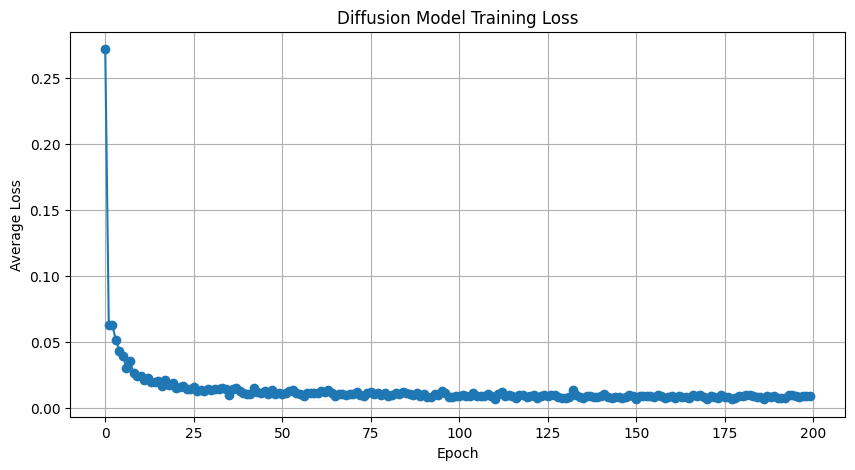

In [10]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Diffusion Model Training Loss')
plt.grid(True)
plt.savefig('/kaggle/working/training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

In [11]:
@torch.no_grad()
def sample(model, class_id, n=50):
    model.eval()
    x = torch.randn(n, 3, IMAGE_SIZE, IMAGE_SIZE, device=DEVICE)
    y = torch.full((n,), int(class_id), device=DEVICE, dtype=torch.long)

    alphas = 1.0 - betas
    alpha_hat = torch.cumprod(alphas, dim=0)

    for i in reversed(range(TIMESTEPS)):
        t = torch.full((n,), i, device=DEVICE, dtype=torch.long)
        eps = model(x, t, y)

        a = alphas[i]
        ah = alpha_hat[i]
        b = betas[i]

        if i > 0:
            z = torch.randn_like(x)
        else:
            z = torch.zeros_like(x)

        # DDPM reverse step
        x = (1.0 / a.sqrt()) * (x - (b / (1.0 - ah).sqrt()) * eps) + b.sqrt() * z

    return x

In [12]:
# Load trained model (use this if restarting kernel after training)
model = ImprovedUNet(NUM_CLASSES, TIMESTEPS).to(DEVICE)
model.load_state_dict(torch.load("/kaggle/working/diffusion_model_v2.pth"))
model.eval()
print("Model loaded successfully!")

Model loaded successfully!


In [13]:
os.makedirs("/kaggle/working/train_synthetic", exist_ok=True)

ntl_images = sample(model, class_id=3, n=40)
ntl_images = (ntl_images + 1) / 2  # back to [0,1]

for i, img in enumerate(ntl_images):
    save_image(img, f"/kaggle/working/train_synthetic/NTL_synth_{i}.png")

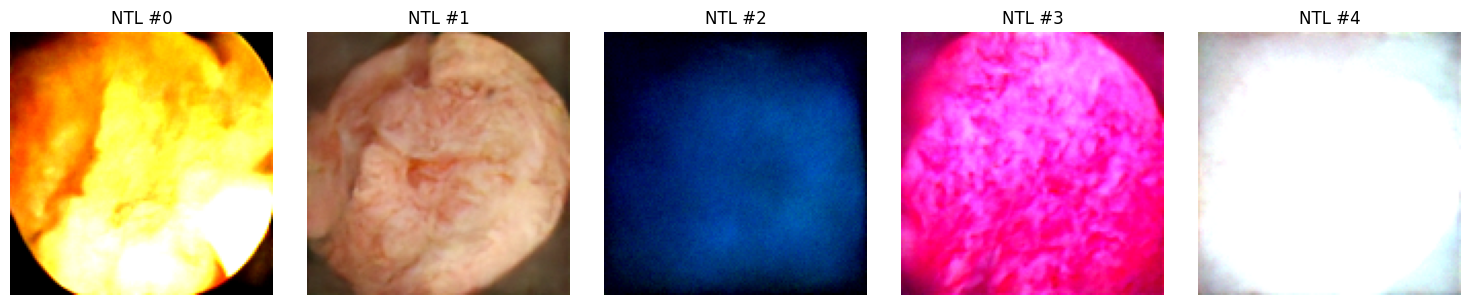

In [14]:
# Display 5 generated images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = ntl_images[i].cpu().permute(1, 2, 0).numpy()
    img = img.clip(0, 1)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'NTL #{i}')
plt.tight_layout()
plt.show()

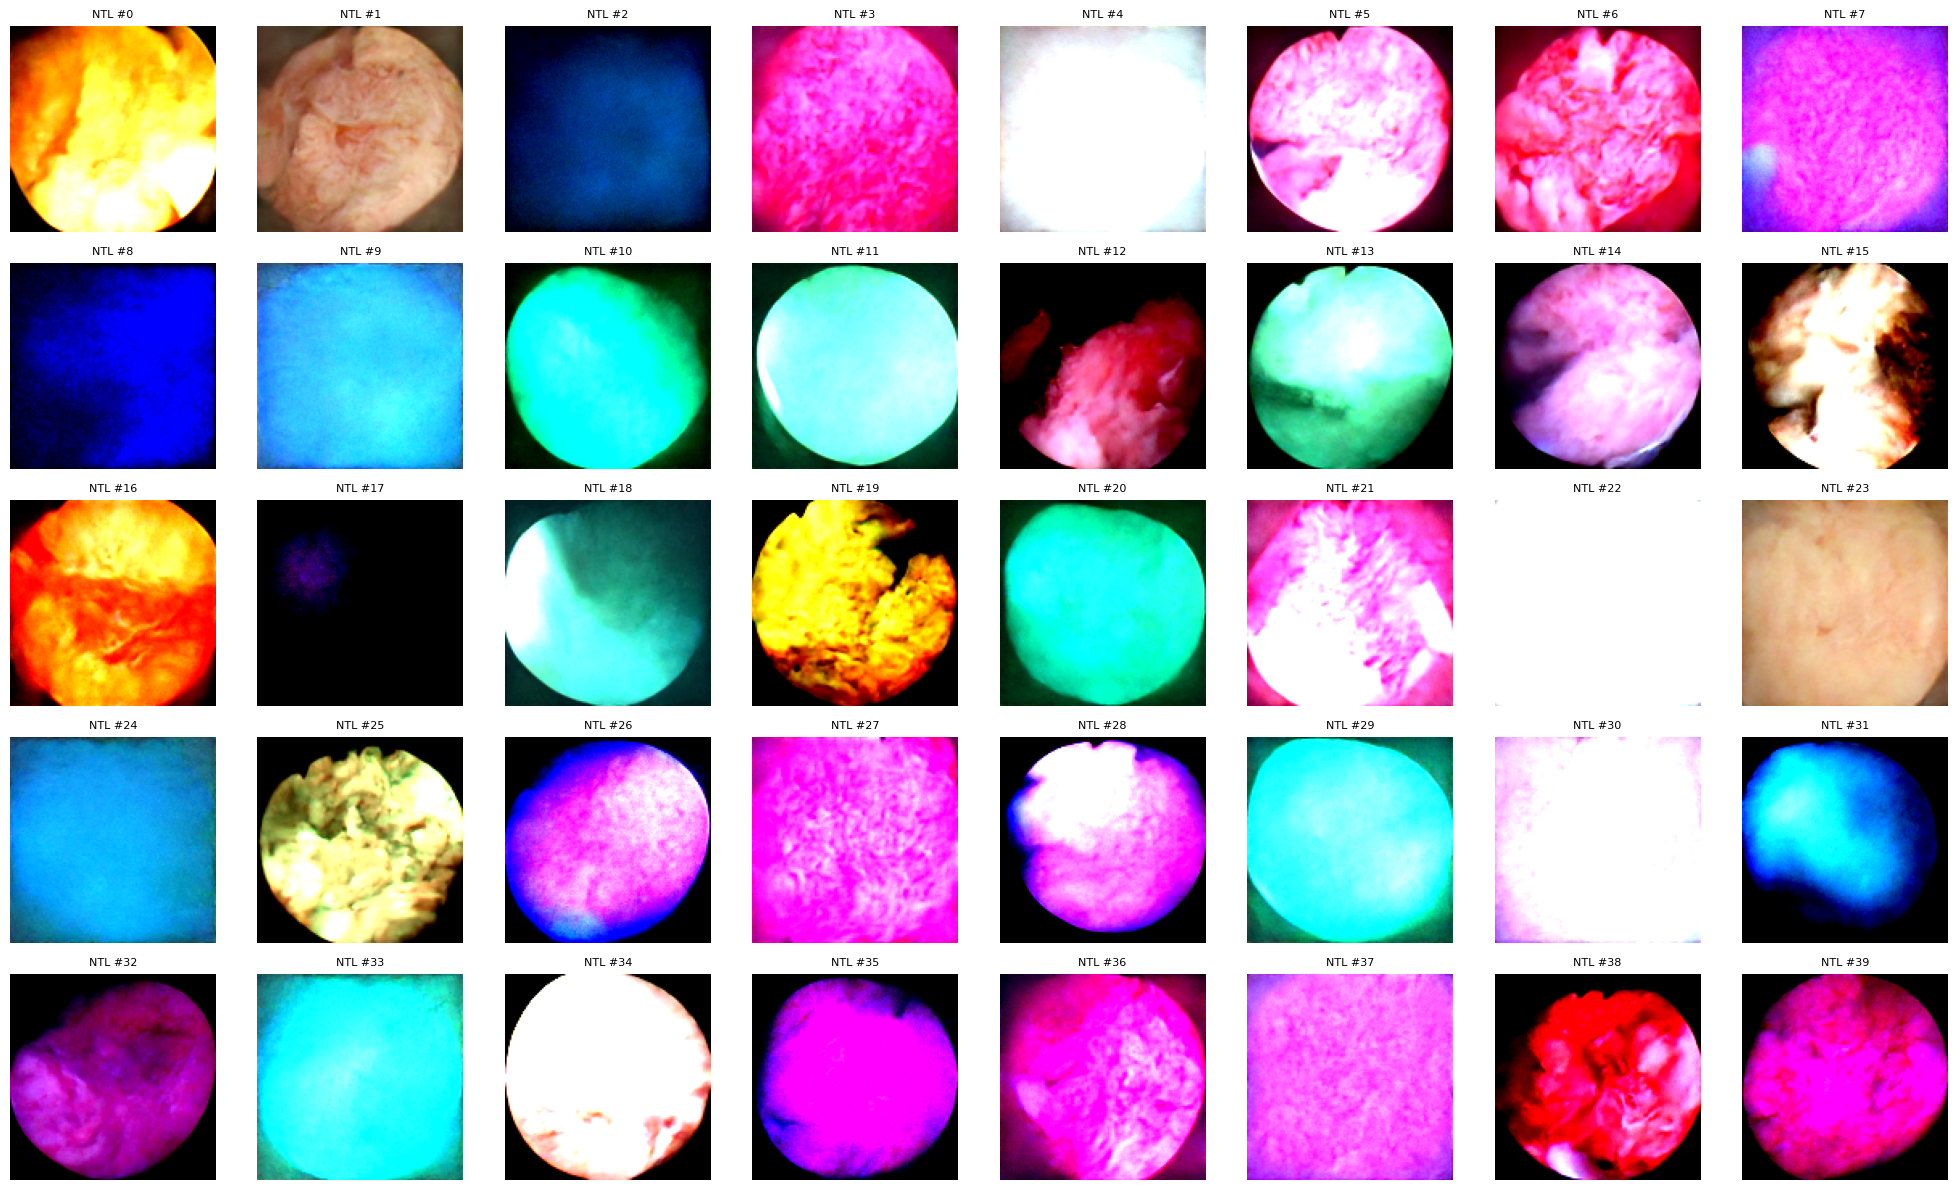

In [15]:
# Display all 40 generated images in a grid
fig, axes = plt.subplots(5, 8, figsize=(20, 12))
axes = axes.flatten()
for i in range(40):
    img = ntl_images[i].cpu().permute(1, 2, 0).numpy()
    img = img.clip(0, 1)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'NTL #{i}', fontsize=8)
plt.tight_layout()
plt.savefig('/kaggle/working/generated_samples_grid.png', dpi=150, bbox_inches='tight')
plt.show()